# Question Generation For Retrieval Evaluation
MLflow provides an advanced framework for constructing Retrieval-Augmented Generation (RAG) models.
RAG is a cutting edge approach that combines the strengths of retrieval models (a model that chooses and ranks relevant 
chunks of a document based on the user's question) and generative models.
It effectively merges the capabilities of searching and generating text to provide responses that are contextually
relevant and coherent, allowing the generated text to make reference to existing documents. RAG leverges the retriever to find context documents, and
this novel approach has revolutionized various NLP tasks.

Naturally, we want to be able to evaluate this retriever system for the RAG model to compare and judge its
performance. To evaluate a retriever system, we would first need a test set of questions on the documents.
These questions need to be diverse, relevant, and coherent. Manually generating questions may be challenging
because it first requires you to understand the documents, and spend lots of time coming up with questions 
for them. 

We want to make this process simpler by utilizing an LLM to generate questions for this test set. This
tutorial will walk through how to generate the questions and how to analyze the diversity and relevance
of the questions.

## Step 1: Install and Load Packages

In [1]:
import os
import json
from langchain.text_splitter import CharacterTextSplitter
import openai

# For scraping
import requests
import pandas as pd
from bs4 import BeautifulSoup

# For data analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from langchain.embeddings import OpenAIEmbeddings
import numpy as np
import random

## Step 2: Set OpenAI Key
The question generation system can be done using any LLM. We chose to use OpenAI here, so we will need their API key.

In [2]:
openai.api_key = "<redacted>"
os.environ["OPENAI_API_KEY"] = openai.api_key

## Step 3: Decide on Chunk Size

In [3]:
CHUNK_SIZE = 1500
# Choose a seed for reproducible results
SEED = 2023

## Step 4: Prepare Document Data

### 4.1 Scrape the documents from the MLflow website

In [4]:
page = requests.get("https://mlflow.org/docs/latest/index.html")
soup = BeautifulSoup(page.content, "html.parser")

mainLocation = "https://mlflow.org/docs/latest/"
header = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11",
    "Accept-Language": "en-US,en;q=0.8",
    "Connection": "keep-alive",
}

data = []
for a_link in soup.find_all("a"):
    document_url = mainLocation + a_link["href"]
    page = requests.get(document_url, headers=header)
    soup = BeautifulSoup(page.content, "html.parser")
    file_to_store = a_link.get("href")
    if soup.find("div", {"class": "rst-content"}):
        data.append(
            [file_to_store, soup.find("div", {"class": "rst-content"}).text.replace("\n", " ")]
        )

df = pd.DataFrame(data, columns=["source", "text"])
df.head(3)

/Users/liang.zhang/miniconda3/envs/mlflow-dev-env/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


,source,text
0,introduction/index.html,Documentation What is MLflow? What i...
1,getting-started/index.html,Documentation Getting Started with MLflow ...
2,new-features/index.html,Documentation New Features New Featu...


In [5]:
# Save the results to the disk and load them back to avoid re-running the scraping process
# if you want to re-run the rest of the notebook with different parameters
df.to_csv("mlflow_docs_scraped.csv", index=False)
df = pd.read_csv("mlflow_docs_scraped.csv")

### 4.2 Select a subset of the documents and split them into chunks

In [6]:
# For demonstration purposes, let's pick 5 popular MLflow documantation pages from the dataset
mask = df["source"].isin(
    {
        "tracking.html",
        "models.html",
        "model-registry.html",
        "search-runs.html",
        "projects.html",
    }
)
sub_df = df[mask]

In [7]:
# Split documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, separator=" ")


def get_chunks(input_row):
    new_rows = []
    chunks = text_splitter.split_text(input_row["text"])
    for i, chunk in enumerate(chunks):
        new_rows.append({"chunk": chunk, "source": input_row["source"], "chunk_index": i})
    return new_rows


expanded_df = pd.DataFrame(columns=["chunk", "source", "chunk_index"])

for index, row in sub_df.iterrows():
    new_rows = get_chunks(row)
    expanded_df = pd.concat([expanded_df, pd.DataFrame(new_rows)], ignore_index=True)

expanded_df

,chunk,source,chunk_index
0,Documentation MLflow Tracking MLflow Tracking ...,tracking.html,0
1,Tags Concepts MLflow Tracking is organized aro...,tracking.html,1
2,"runs into experiments, which group together ru...",tracking.html,2
3,"or as databricks://<profileName>, a Databricks...",tracking.html,3
4,Many developers run MLflow on their local mach...,tracking.html,4
...,...,...,...
248,"Containing Special Characters When a metric, p...",search-runs.html,2
249,= 'models:/mymodel/1' attributes.status = 'ACT...,search-runs.html,3
250,expression to be a constant. The type of the c...,search-runs.html,4
251,"run_view_type=ViewType.ACTIVE_ONLY, max_result...",search-runs.html,5


In [12]:
# For cost-saving purposes, let's pick the first 4 chunks from each doc
# To generate questions with more chunks, change the start index and end index in iloc[]
grouped = expanded_df.groupby("source")
filtered_df = pd.DataFrame()
for name, group in grouped:
    filtered_df = pd.concat([filtered_df, group.iloc[0:4]])
filtered_df = filtered_df.reset_index(drop=True)

## Step 5: Generate questions
The prompt below instructs the LLM to generate a question for each given chunk, and also generate an answer to the question to make it easier to do human validation. Also, return the results in a structured format.

This example uses OpenAI's gpt-3.5-turbo model to generate the questions, you can replace it with the LLM that works best for your use case.

In [9]:
def generate_question_answer(content):
    prompt = f"""Please generate a question asking for the key information in the given paragraph. Also answer the questions using the information in the given paragraph. Please ask the specific question instead of the general question, like 'What is the key information in the given paragraph?'. Please generate the answer using as much information as possible. If you are unable to answer it, please generate the answer as 'I don't know.' The answer should be informative and should be more than 3 sentences.
    
Paragraph: {content}

Please call the submit_function function to submit the generated question and answer.
    """

    messages = [{"role": "user", "content": prompt}]

    submit_function = {
        "name": "submit_function",
        "description": "Call this function to submit the generated question and answer.",
        "parameters": {
            "type": "object",
            "properties": {
                "question": {
                    "type": "string",
                    "description": "The question asking for the key information in the given paragraph.",
                },
                "answer": {
                    "type": "string",
                    "description": "The answer to the question using the information in the given paragraph.",
                },
            },
            "required": ["question", "answer"],
        },
    }

    response = openai.ChatCompletion.create(
        messages=messages,
        model="gpt-3.5-turbo",
        functions=[submit_function],
        function_call="auto",
        temperature=0.0,
        seed=SEED,
    )
    try:
        func_args = json.loads(response["choices"][0]["message"]["function_call"]["arguments"])
        question = func_args["question"]
        answer = func_args["answer"]
        return question, answer
    except Exception as e:
        return str(e), "N/A"

In [10]:
queries = []

In [ ]:
n = len(filtered_df)
for i, row in filtered_df.iterrows():
    chunk = row["chunk"]
    question, answer = generate_question_answer(chunk)
    print(f"{i+1}/{n}: {question}")
    queries.append(
        {
            "question": question,
            "answer": answer,
            "chunk": chunk,
            "chunk_id": row["chunk_index"],
            "source": row["source"],
        }
    )
result_df = pd.DataFrame(queries)

Sometimes, the LLM may fail to generate a question. We can examine the data above to see whether there are any errors. If so, remove the error records.

In [ ]:
result_df = result_df[result_df["answer"] != "N/A"]

In [13]:
# Save the results to a csv file
result_df.to_csv("question_answer_source.csv")
result_df = pd.read_csv("question_answer_source.csv")

## Quality Analysis of Questions Generated (Optional)
If you would like to compare quality of questions generated across different prompts, we can
analyze the quality of questions manually and in aggregate. We want to evaluate questions 
along two dimensions - their diversity and relevance.

Note: There isn't a well-defined way to analyze the quality of generated questions, so this is just one approach you can take to gain insight into how diverse and relevant your generated questions are.

### Evaluating Diversity of Questions

Diversity of questions is important because we want questions to cover the majority of the
document content. In addition, we want to be able to evaluate the retriever with different 
forms of questioning. We want to be able to have harder questions and easier questions. All
of these are not straightforward to analyze, and we decided to analyze its through question
length and latent space embeddings.

#### Length
Length gives a sense of how diverse the questions are. Some questions may be wordy while
others are straight to the point. It also allows us to identify problems with the question
generated. For example, you may identify some questions to have a length of 0.

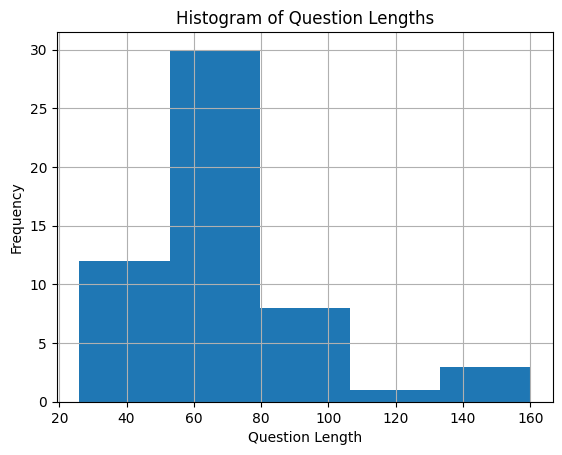

In [14]:
# Length
questions = result_df["question"].to_list()
question_len = pd.DataFrame([len(q) for q in questions], columns=["length"])
question_len.hist(bins=5)
plt.title("Histogram of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

In addition to visual representation, we also want to look at more concrete percentile values.


In [15]:
# Calculating percentile values
p10 = int(question_len["length"].quantile(0.10))
p90 = int(question_len["length"].quantile(0.90))
print("p10-p90 range is", p90 - p10)

p10-p90 range is 45


There are also a couple queries that are longer than normal. However, these seem fine.

In [16]:
[q for q in questions if len(q) > 100]

['What is a common configuration for lowering the total memory pressure for pytorch models within transformers pipelines?',
 'How can you get all active runs from experiments IDs 3, 4, and 17 that used a CNN model with 10 layers and had a prediction accuracy of 94.5% or higher?',
 'How can you get all active runs from experiments IDs 3, 4, and 17 that used a CNN model with 10 layers and had a prediction accuracy of 94.5% or higher?',
 'What interfaces does the MLflow client use to record MLflow entities and artifacts when running MLflow on a local machine with a SQLAlchemy-compatible database?']

#### Latent Space
Latent space embeddings contain semantic information about the question. This can be used to 
evaluate the diversity and the difference between two questions semantically. To do so, we will need to map the
high dimensional space to a lower dimensional space. We utilize PCA and TSNE to map the embeddings 
into a 2-dimensional space for visualization.

We append 5 benchmark queries to help visualize how diverse the questions are. The first four of these questions are semantically similar and all asking about MLflow, while the last is different and refers to RAG.

In [17]:
benchmark_questions = [
    "What is MLflow?",
    "What is MLflow about?",
    "What is MLflow Tracking?",
    "What is MLflow Evaluation?",
    "Why is RAG so popular?",
]
questions_to_embed = questions + benchmark_questions

We apply PCA to reduce the embedding dimensions to 10 before applying TSNE to reduce it to 2 dimensions, as recommended by sklearn due to the computational complexity of TSNE.

In [18]:
# Apply embeddings
embeddings = OpenAIEmbeddings()
question_embeddings = embeddings.embed_documents(questions_to_embed)
# PCA on embeddings to reduce to 10-dim
pca = PCA(n_components=10)
question_embeddings_reduced = pca.fit_transform(question_embeddings)
# TSNE on embeddings to reduce to 2-dim
tsne = TSNE(n_components=2, random_state=SEED)
lower_dim_embeddings = tsne.fit_transform(question_embeddings_reduced)

Now that we have 2-dimensional embeddings representing the semantics of the question, we can visualize it with a scatter plot, differentiating the generated questions and the benchmark questions.

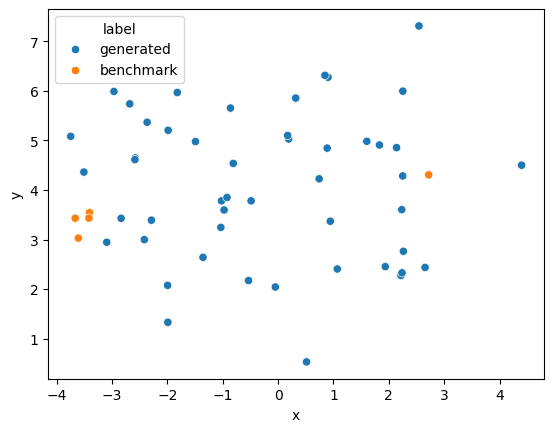

In [19]:
labels = np.concatenate(
    [
        np.full(len(lower_dim_embeddings) - len(benchmark_questions), "generated"),
        np.full(len(benchmark_questions), "benchmark"),
    ]
)
data = pd.DataFrame(
    {"x": lower_dim_embeddings[:, 0], "y": lower_dim_embeddings[:, 1], "label": labels}
)
sns.scatterplot(data=data, x="x", y="y", hue="label");

Observe that within the orange points on the scatter plot, there is one point that is further than the others. That is the unique benchmark question about RAG. This plot gives a sense of the diversity of the questions generated.

### Evaluate Document Relevance
Another important axis to consider is how relevant the questions are to the document we provided. We want to understand whether the questions generated by the LLM is actually referring to our provided text, or whether it is hallucinating irrelevant questions. We will evaluate relevance by first manually checking certain questions against their document chunk. Then, we define a measure of relevance to analyze it quantitatively.

#### Manual Checking of Document Relevance

Manual qualitative check of whether the questions are relevant to the document.

In [20]:
display(result_df.sample(3))

,Unnamed: 0,question,answer,chunk,chunk_id,source
52,53,What is the default backend store used by MLflow?,The default backend store used by MLflow is th...,are used. The default is local FileStore. For ...,5,tracking.html
26,27,What are the entry points in a MLproject file ...,The entry points in a MLproject file are the ....,might have a single Git repository containing ...,1,projects.html
1,1,What is the purpose of saving the model in pic...,The purpose of saving the model in pickled for...,# Make predictions using the testing set diabe...,15,model-registry.html


#### Embeddings Cosine Similarity

The embedding of the chunk and query is placed in the same latent space, and the retriever model would extract similar chunk embeddings to a query embedding. Hence, relevance for the retriever is defined by the distance of embeddings in this latent space.

Cosine similarity is a measure of vector similarity, and can be used to determine the distance of embeddings between the chunk and the query. It is a distance metric that approaches 1 when the question and chunk are similar, and becomes 0 when they are different.

We can use the cosine similarity score directly to measure the relevancy.

In [21]:
embedded_queries = result_df.copy()
embedded_queries["chunk_emb"] = result_df["chunk"].apply(
    lambda x: np.squeeze(embeddings.embed_documents([x]))
)
embedded_queries["question_emb"] = result_df["question"].apply(
    lambda x: np.squeeze(embeddings.embed_documents([x]))
)

In [22]:
def cossim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


embedded_queries["cossim"] = embedded_queries.apply(
    lambda row: cossim(row["question_emb"], row["chunk_emb"]), axis=1
)

After we score each question by its relative relevancy, we can evaluate the generated questions as a whole.

(array([ 1.,  7., 15., 20., 11.]),
 array([0.72731436, 0.7629336 , 0.79855285, 0.8341721 , 0.86979135,
        0.9054106 ]),
 <BarContainer object of 5 artists>)

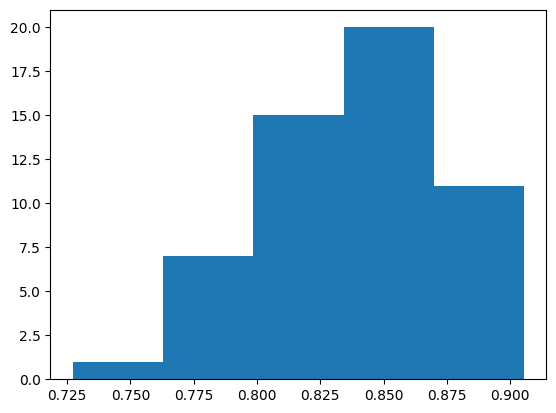

In [23]:
scores = embedded_queries["cossim"].to_list()
plt.hist(scores, bins=5)

There are a couple lower scores. Let's take a look at them.

In [24]:
mask = embedded_queries["cossim"] < 0.76
lower_cossim = embedded_queries[mask]
display(lower_cossim)

,Unnamed: 0,question,answer,chunk,chunk_id,source,chunk_emb,question_emb,cossim
49,50,What is the purpose of the 'experimentIds' var...,The 'experimentIds' variable is used to store ...,API. List<Long> experimentIds = Arrays.asList(...,6,search-runs.html,"[-0.0224397570176948, -0.01785830753462161, 0....","[-0.010870431773125582, 0.011472354827119134, ...",0.727314


Manual inspection of these less relevant questions reveals that some chunks are less informative or mainly consists of code, hence the generated question might be less useful. You can choose to filter these as desired.